In [1]:
!nvidia-smi

Sun Mar  3 16:00:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# import tensorflow as tf

# # Define tand get the number os devices. 
# strategy = tf.distribute.MirroredStrategy()
# print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

In [3]:
import keras

2024-03-03 16:00:12.396033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 16:00:12.396104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 16:00:12.397938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.xception.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.xception.preprocess_input,
)

test_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.xception.preprocess_input
)

In [21]:
target_size = (142, 142)
batch_size = 32
# batch_size = 32 * strategy.num_replicas_in_sync

train_images = train_generator.flow_from_directory(
    "/kaggle/input/refinedsplit/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    color_mode="rgb",
    seed=42
)

val_images = val_generator.flow_from_directory(
    "/kaggle/input/refinedsplit/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    color_mode="rgb",
    seed=42
)

test_images = test_generator.flow_from_directory(
    "/kaggle/input/refinedsplit/test",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    color_mode="rgb",
    seed=42
)

Found 14700 images belonging to 21 classes.
Found 3150 images belonging to 21 classes.
Found 3150 images belonging to 21 classes.


In [6]:
from keras.applications import Xception
from keras.models import Sequential
from keras import regularizers
from keras.layers import BatchNormalization

pretrained_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(target_size[0], target_size[1], 3),
    pooling="max"
)

pretrained_model.trainable = False

from keras.callbacks import ModelCheckpoint

checkpoint_path = "checkpoints"
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    save_weights_only=True,
    monitor="val_accuracy",
)

from keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(
    monitor = "val_loss", # watch the val loss metric
    patience = 5,
    restore_best_weights = True
)

In [7]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, GaussianNoise, Conv2D, BatchNormalization, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam

def build_model():

    num_classes = train_images.num_classes

    # Load the pre-trained Xception model
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

    # Freeze the layers in the base model
    base_model.trainable = False

    # Create a new model with improvements
    model = Sequential([
        base_model,
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        GaussianNoise(0.3),
        Dense(512, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
# with strategy.scope():
#     multi_gpu_model = build_model()
multi_gpu_model = build_model()
multi_gpu_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 conv2d_8 (Conv2D)           (None, 5, 5, 256)         4718848   
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 256)         0         
 D)                                                              
                                                                 
 batch_normalization_8 (Bat  (None, 2, 2, 256)         1024      
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 2, 512)         1180160   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 512)         0

In [9]:
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
import numpy as np

# Assuming you have already created the test_generator as mentioned in your code

# Get one batch of images from the generator
batch = next(test_images)

# Retrieve the first image from the batch
image_array = batch[0]

# Convert the image array to a PIL Image or matplotlib plot (optional)
img = image.array_to_img(image_array)

# Convert the PIL Image to a format suitable for your model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Now, you can use img_array for prediction
warmup_results = multi_gpu_model.predict(img_array)

1/1 [==============================] - 3s 3s/step


In [10]:
history = multi_gpu_model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping_cb,
        checkpoint_cb,
    ]
)

Epoch 1/100


I0000 00:00:1709481636.818294    4252 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


460/460 [==============================] - 154s 308ms/step - loss: 2.4329 - accuracy: 0.3110 - val_loss: 1.2749 - val_accuracy: 0.6200
Epoch 2/100
460/460 [==============================] - 134s 291ms/step - loss: 1.7295 - accuracy: 0.4922 - val_loss: 1.1111 - val_accuracy: 0.6498
Epoch 3/100
460/460 [==============================] - 127s 276ms/step - loss: 1.4855 - accuracy: 0.5520 - val_loss: 1.0158 - val_accuracy: 0.6771
Epoch 4/100
460/460 [==============================] - 114s 247ms/step - loss: 1.3877 - accuracy: 0.5827 - val_loss: 1.0029 - val_accuracy: 0.6863
Epoch 5/100
460/460 [==============================] - 118s 256ms/step - loss: 1.2865 - accuracy: 0.6141 - val_loss: 0.9246 - val_accuracy: 0.7054
Epoch 6/100
460/460 [==============================] - 122s 265ms/step - loss: 1.2370 - accuracy: 0.6254 - val_loss: 0.9105 - val_accuracy: 0.7079
Epoch 7/100
460/460 [==============================] - 120s 260ms/step - loss: 1.1563 - accuracy: 0.6477 - val_loss: 0.8933 - val_

In [11]:
multi_gpu_model.save(f'/kaggle/working/model.keras')

In [22]:
results = multi_gpu_model.evaluate(test_images)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

99/99 [==============================] - 6s 63ms/step - loss: 0.8043 - accuracy: 0.7495
    Test Loss: 0.80429
Test Accuracy: 74.95%


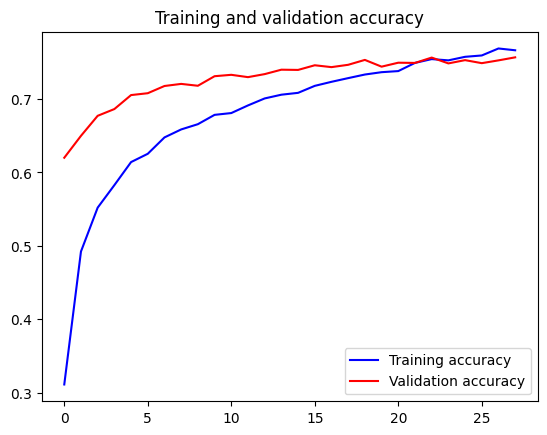

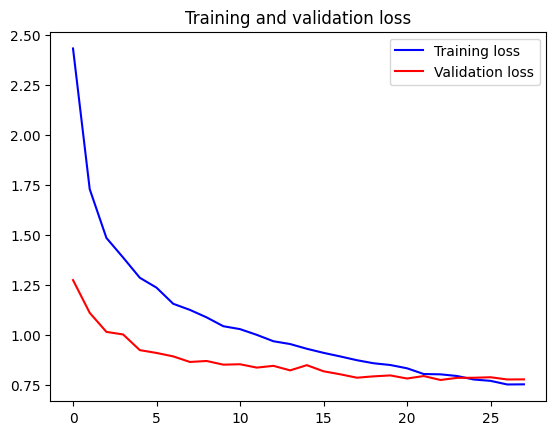

In [13]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()